In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

In [22]:
path = 'data/kaari2132023.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

df = pd.read_csv(path, dtype=dtypes)

df['datetime'] = pd.to_datetime(df['datetime'])

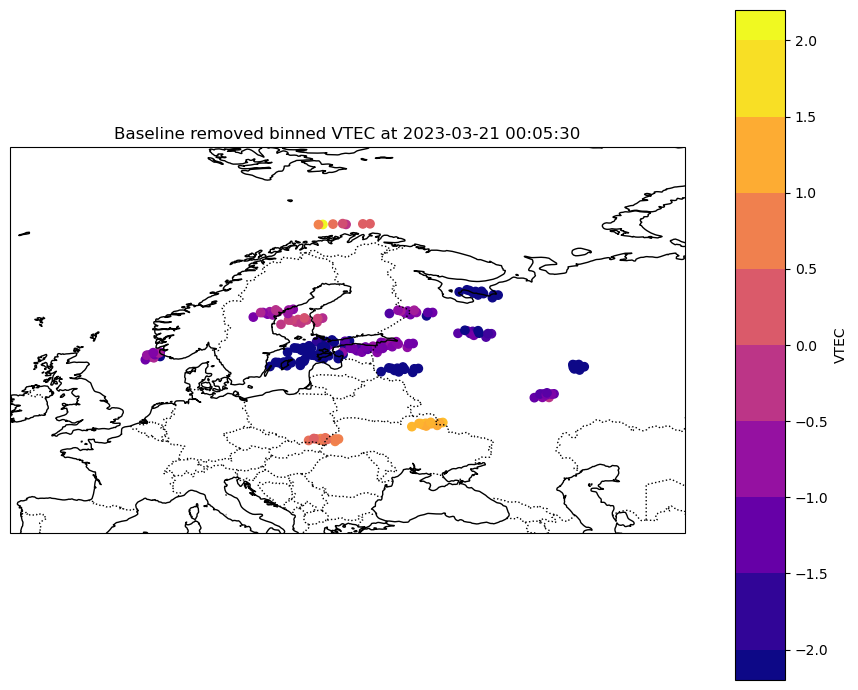

In [23]:
def create_fig_s(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

def show_fig(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_s(fig, ax, datetime, df, RES)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig(frames[11], df, RES=0.5)

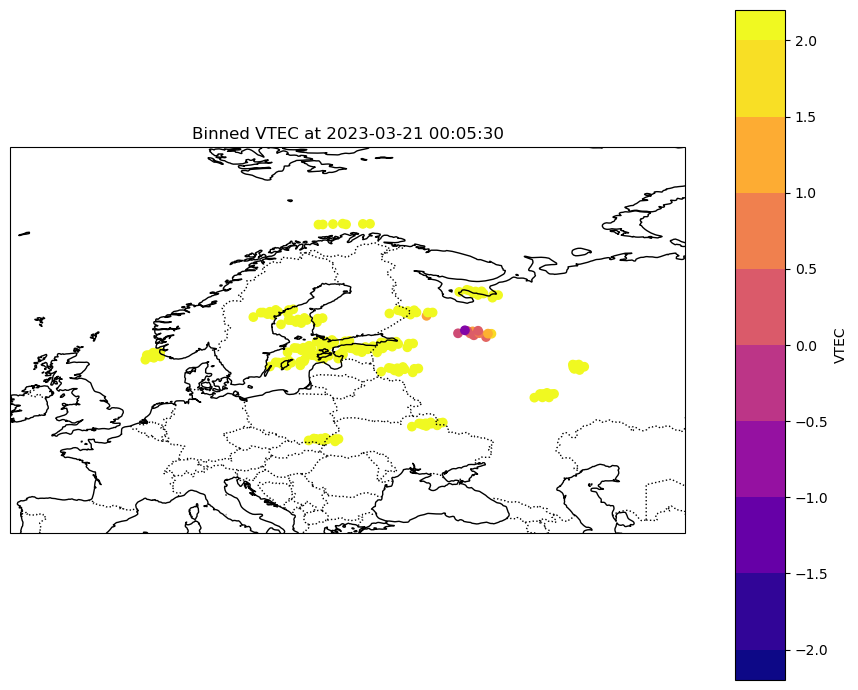

In [34]:
def create_fig_tec(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['tec'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Binned VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

def show_fig_tec(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_tec(fig, ax, datetime, df, RES)
    plt.show(fig)

frames = sorted(df['datetime'].unique())
show_fig_tec(frames[11], df, RES=0.5)

In [26]:
def create_fig(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed binned VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array

MovieWriter imagemagick unavailable; using Pillow instead.


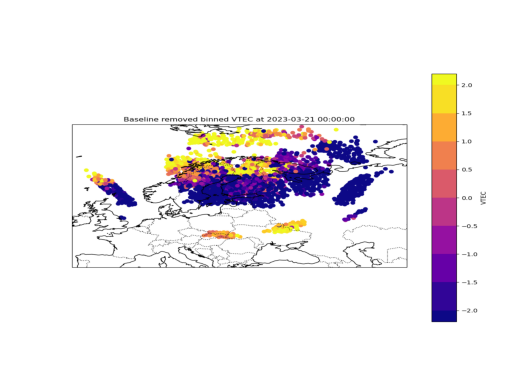

In [27]:
def update(frame):
    heatmap = create_fig(frame, df)
    ax.clear()
    ax.imshow(heatmap, aspect='auto')
    ax.axis('off') 

frames = sorted(df['datetime'].unique())
fig,ax = plt.subplots()

animation = FuncAnimation(fig, update, frames=frames, interval=100)

# Save the animation as a GIF file
animation.save('heatmap_animation.gif', writer='imagemagick')

# Save the animation as an MP4 file (requires ffmpeg or avconv installed)
# animation.save('animations/heatmap_animation_sg.mp4', writer='ffmpeg')

In [28]:
DATETIME = frames[1]
df2 = df.loc[df['datetime'] == DATETIME]
df2.shape

(3477, 18)

In [29]:
DATETIME = frames[11]
df1 = df.loc[df['datetime'] == DATETIME]
df1.shape

(193, 18)

In [30]:
grouped = df.groupby('datetime').filter(lambda x: len(x) <= 1000)
print(len(grouped['datetime'].unique()), len(df['datetime'].unique()))

640 2880


MovieWriter imagemagick unavailable; using Pillow instead.


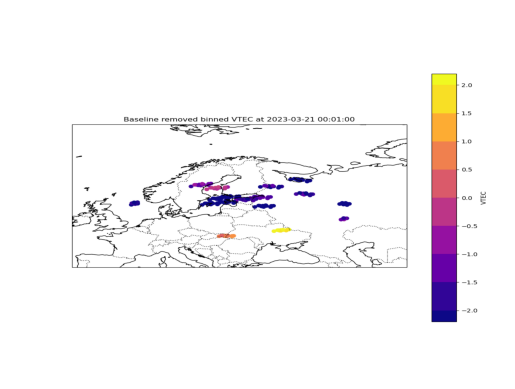

In [31]:
fig,ax = plt.subplots()

animation = FuncAnimation(fig, update, frames=timestamps, interval=50)

# Save the animation as a GIF file
animation.save('heatmap_animation_blips.gif', writer='imagemagick')

In [32]:
df.loc[df['datetime'].isin(timestamps)].nunique()

datetime        640
gps_site         11
sat_id           30
gdlatr           11
gdlonr           11
los_tec      120045
tec          120059
azm          120240
elm          120097
gdlat        118182
glon         119878
gnss_type         2
slant_f      120097
vtec         120402
pair_id         550
curve_id          4
filtered     120402
blrmvd       120402
dtype: int64

In [33]:
df.nunique()

datetime        2880
gps_site         207
sat_id            30
gdlatr           200
gdlonr           201
los_tec      6887591
tec          6501890
azm          7237179
elm          6790144
gdlat        3272887
glon         6472208
gnss_type          2
slant_f      6790144
vtec         8013205
pair_id        10284
curve_id          10
filtered     8013924
blrmvd       8013924
dtype: int64

In [36]:
def create_fig_tec(datetime, df, RES=0.5, METHOD='nearest'):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['tec'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Binned VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    heatmap_array = np.array(Image.open(buf))
    return heatmap_array

MovieWriter imagemagick unavailable; using Pillow instead.


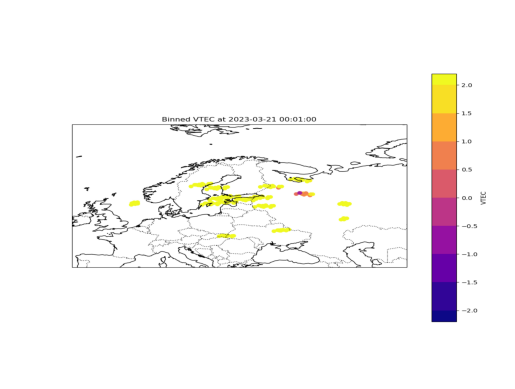

In [37]:
def update_tec(frame):
    heatmap = create_fig_tec(frame, df)
    ax.clear()
    ax.imshow(heatmap, aspect='auto')
    ax.axis('off') 

frames = sorted(df['datetime'].unique())
fig,ax = plt.subplots()

animation = FuncAnimation(fig, update_tec, frames=timestamps, interval=50)

# Save the animation as a GIF file
animation.save('heatmap_animation_tec.gif', writer='imagemagick')

# Save the animation as an MP4 file (requires ffmpeg or avconv installed)
# animation.save('animations/heatmap_animation_sg.mp4', writer='ffmpeg')